# ニューラルネットワークの実装 1 （分類）

本章では、数学の章で学んだニューラルネットワークの実装をオープンソースフレームワークである **TensorFlow** を使ってを行います。  

## 本章の構成

- TensorFlow の基礎
- TensorFlow による分類モデルの学習
- 学習済みモデルの保存と推論

## TensorFlow の基礎

![TensorFlow](http://drive.google.com/uc?export=view&id=1Bnf_KGHYGRGzlirq6WHP_T2VQZ0ACM9J)

*TensorFlow, the TensorFlow logo and any related marks are trademarks of Google Inc.*

[TensorFlow](https://www.tensorflow.org/) とは、Google 社開発している機械学習のためのエンドツーエンドのオープンソースプラットフォームです。ソースコードは[こちら](https://github.com/tensorflow/tensorflow)から確認することができます。    

### TensorFlow の特徴

TensorFlow の特徴には下記の 3 点が挙げられます。  

- 初心者にも使いやすいインターフェースで作られている
- ユーザー数が多いため、世界中の人からの情報が集まるコミュニティがある
- エッジデバイスへの連携や分散処理、学習可視化ソフトなどモデル作成以外の部分も包括的なエコシステムがある

こういった理由からも、初学者にとっておすすめのフレームワークになります。まずは TensorFlow で大枠を掴んだあとに PyTorch などの他のフレームワークを使用することをおすすめします。    


### Keras とは

[Keras](https://www.tensorflow.org/guide/keras) とは TensorFlow でディープラーニングのモデルの構築及び学習を行うことが可能な高レベルな API です。Keras には大きく 3 種類の API （実装方法）が存在します。  

- [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)
- [Functional API](https://www.tensorflow.org/guide/keras/functional)
- [Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

Sequential API は比較的単純なモデルの構築を簡単かつ、短いコードで実装を行うことが可能です。本講座では、主にこの Sequetial API を用いてディープラーニングのモデルの構築を行います。  
Functional API や Subclassing API を使うと、複雑なモデルの構築も可能です。  

### TensorFlow の読み込み

TensorFlow は Google Colaboratory 上で既にインストールされているため、そのまま読み込む事が可能です。TensorFlow は読み込む際に `tf` として省略することが慣例になっています。  

また、Colab ではデフォルトではバージョン 1.x 系が読み込まれる設定となっています。2020 年 2 月現在では 2.1.0 が最新となっており、2.x 系がこれからのデフォルトに変わっていきますので本講座では 2.x 系を使っていきます。  

In [41]:
# ライブラリの読み込み
import tensorflow as tf

In [42]:
#　バージョンの確認
print(tf.__version__)

2.19.0


TensorFlow を扱っていく上で、モデル構築には TensorFlow 内部に組み込まれている Keras を使用して実装を行っていきます。  

## TensorFlow による分類モデルの学習

ニューラルネットワークのモデル構築・学習を行います。流れは下記の 5 点を意識します。  

1. データセットの準備
2. ネットワークの構築
3. 目的関数・最適化手法の選択
4. ネットワークの学習
5. 予測精度の評価

### データセットの準備

今回は scikit-learn に準備されている[乳がんに関するデータセット](https://goo.gl/U2Uwz2)を用い、クラス分類を通して実装方法を学びます。  
今回使用するデータセットの目的変数には、乳がんが陽性 (0)　もしくは、陰性 (1) の 2 種類の値を持ちます。また、入力変数には乳がんの検査で採取された細胞に関する情報を持ちます。  

入力変数の詳細に関しては[こちら](https://goo.gl/U2Uwz2)を参照して下さい。

（scikit-learn ではデータ取得時に NumPy の ndarray オブジェクトでデータが保存されていますが、今回 csv ファイルから読み込んだデータを学習に使用することを想定し、一度 Pandas の DataFrame オブジェクトに変換してから実装を行います。）

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

In [44]:
# データセットの読み込み
dataset = load_breast_cancer()
colms_name = dataset.feature_names
x = dataset.data
t = dataset.target

In [45]:
# 読み込んだデータセットをデータフレームに変換
df = pd.DataFrame(data=x, columns=colms_name)
df['Target'] = t
df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


Target の列が目的変数、その他の列を入力変数とし、乳がんが陽性 / 陰性の 2 値の分類を行います。  
データセットの中身を簡単に確認しておきます。  

In [46]:
# サンプル数（行数）、入力・目的変数の数（列数）の確認
df.shape

(569, 31)

今回はサンプル数が 569 、入力変数が 30 、目的変数の数が 1 であることが確認できます。  
この**入力変数の数はニューラルネットワークの入力層のノードの数となります。**

In [47]:
# 分類するクラスの種類の確認
df['Target'].unique()

array([0, 1])

目的変数の種類は 0 ~ 1 の 2 種類が存在します。このようにまずデータセットの全体像を理解する癖を付けるようにしておきましょう。  

**2 種類の分類になるため、ニューラルネットワークの出力層のノードの数は 2 になります。**

#### 入力変数と目的変数の切り分け

TensorFlow を用いて、ニューラルネットワークの学習を実装する際も scikit-learn を用いての機械学習アルゴリズムの実装と同様にデータセットの入力変数と目的変数の切り分けを行う必要があります。

In [48]:
# 入力変数（Target 列以外の列を取得）
x = df.drop('Target', axis=1)

# 目的変数（Target の列のみを取得）
t = df['Target']

正しく切り分けられているかデータの中身を表示して確認しておきます。

In [49]:
x.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


#### TensorFlow で計算できるデータの形式に変換

TensorFlow で計算を行うためには、下記の 2 点を満たしている必要があります。こちらが指定された形式となっていない場合、学習の際にエラーが出てしまいます。  

- 入力変数や目的変数が NumPy の ndarray オブジェクトである
- 分類の場合、ラベルの最小値が 0 である

**NumPy の ndarray オブジェクトの取得**

まずは、切り出したデータセットの型を確認しましょう。  

In [50]:
type(x)

pandas.core.frame.DataFrame

今回は Pandas でデータセットの読み込みを行ったため、Pandas の DataFrame オブジェクトであることが確認できます。  

この DataFrame 型は　`.values`　という属性の中に NumPy の ndarray オブジェクトを持ちます。

In [51]:
x = x.values
t = t.values

In [52]:
type(x)

numpy.ndarray

TensorFlow の入力値のデータ型は `numpy.float32`、分類問題では目標値のデータ型は `numpy.int32` になっている事が一般的です。 データセットのデータ型の変更を行います。 numpy.ndarray は astype() メソッドを使ってデータ型を変更することができます。

In [53]:
x.dtype

dtype('float64')

In [54]:
# それぞれのデータ型を変換
x = x.astype('float32')
t = t.astype('int32')

In [55]:
x.dtype, t.dtype

(dtype('float32'), dtype('int32'))

**分類の場合、ラベルの最小値が 0 である**

ラベルの最小値が 0 になっているかは、NumPy の `unique` 関数を用いると重複のないユニーク（固有）の値を取り出す事ができます。  

In [56]:
np.unique(t)

array([0, 1], dtype=int32)

今回はラベルが 0 から始まっているので特に変更を加える必要がありません。  

実際には、ラベルが製品名などでついている場合が多いでしょう。その場合は、ラベルを 0 から順につけて行きかつ、そのラベルと製品名が一致するようにデータセットの準備を行う必要があります。  

これでニューラルネットワークの学習に使用するためのデータセットの準備が整いました。最後にそれぞれのデータセットの中身を確認します。

In [57]:
t[:10], type(t)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), numpy.ndarray)

In [58]:
x[:5], type(x)

(array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
         3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
         8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
         3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
         1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
         8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
         3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
         1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
         1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
         1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
         4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
         2.250e-02, 4.5

#### 学習用データセットとテスト用データセットに分割

基礎編で学んだように基本的に機械学習のモデルを学習させる際にはデータセットの分割を行う必要があります。分割するデータセットの種類を確認します。  

| 名称                      | 使用目的                                                     |
  | ------------------------------- | ------------------------------------------------------------ |
  | 学習用データセット (train)      | モデルを学習させるためのデータセット                         |
  | 検証用データセット (validation) | ハイパーパラメータの調整が適切なのか検証するためのデータセット |
  | テスト用データセット (test)     | 学習済みモデルの性能を評価するためのデータセット             |

実際には上記のように 3 種類のデータセットに分割することが望ましいですが、今回は学習用データセット (train) とテスト用データセット (test) の 2 つに分割を行い、ニューラルネットワークの学習・テストを行います。またこのようにデータセットの分割を行い検証を行う方法を[ホールドアウト法](https://ja.wikipedia.org/wiki/%E4%BA%A4%E5%B7%AE%E6%A4%9C%E8%A8%BC)と呼びました。  

分割には scikit-learn に用意されている `model_selection.train_test_split` を使用します。今回は 学習用データセットを 70%、テスト用データセットを 30% とします。  

ここで **再現性の確保** のために引数の `random_state` の値の設定を忘れないようにしましょう。

In [59]:
from sklearn.model_selection import train_test_split

# 学習用データセットとテスト用データセットの分割
x_train, x_test, t_train, t_test = train_test_split(x, t, train_size=0.7, random_state=0)

分割が完了した後は、それぞれのデータセットのサンプル数を確認し、正常に分割できていることを確認しましょう。

In [60]:
x_train.shape, x_train.dtype, x_test.shape, x_test.dtype

((398, 30), dtype('float32'), (171, 30), dtype('float32'))

In [61]:
t_train.shape, t_train.dtype, t_test.shape, t_test.dtype

((398,), dtype('int32'), (171,), dtype('int32'))

### モデルの定義

モデルの定義では、最もシンプルな `tf.keras.Sequential` クラスを使用します。使い方はシンプルで以下の通りです。  

1. `Sequential()` でインスタンス化
2. `layers.層の名前()` で層を定義し、 `add` メソッドでネットワークに追加

この `tf.keras.layers.層の名前()` の部分で全結合層 (`Dense layer`) や活性化関数 (`Activation layer`)、バッチ正規化 (`BatchNormalization layer`) などを追加することができます。    

モデルの定義の前に、乱数のシードの固定も行いましょう。Python 、`random` 関数、 `numpy` そして `tensorflow` それぞのシードの固定を行います。

In [62]:
import os, random

def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed) # random関数のシードを固定
    np.random.seed(seed) # numpyのシードを固定
    tf.random.set_seed(seed) # tensorflowのシードを固定

In [63]:
from tensorflow.keras import models,layers

# シードの固定
reset_seed(0)

# モデルのインスタンス化
model = models.Sequential()

# モデルの定義（層の追加）
model.add(layers.Dense(units=10, input_shape=(30,))) # 入力層
model.add(layers.Activation('relu')) # 活性関数 (ReLU)
model.add(layers.Dense(units=2, input_shape=(10,))) # 出力層
model.add(layers.Activation('softmax')) # ソフトマックス関数（値を 0~1 に変換）

/home/kinoko1943/development/github/TKAdvanced/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


上記のコードでは下記のようなネットワークの構築を行っています。図を確認し、全体像を掴みましょう。    

![定義したネットワークの構造](http://drive.google.com/uc?export=view&id=1k5Wxxhe-2h8cWjV1auKoL4XX05peXd9t)

コードの詳細を確認します。  

- `reset_seed(0)`
  - 先程定義した関数を使用し、シードの固定を行います。ニューラルネットワークの重みはランダムに決定されるため、この乱数のシードを固定することにより再現性を確保します。  

- `models.Sequential()` クラス
  - Sequential モデルのインスタンス化を行います。ニューラルネットワークの定義を行うための箱を準備しているイメージを持つと理解しやすいです。インスタンス化したものを `model` という変数に格納しています。    

- `add()` メソッド
  - 全結合層や活性化関数の層の追加を行います。引数に後述の `layers` モジュールをとります。  

- `layers.Dense()` クラス
  - 全結合層の定義を行うことができます。`units` の引数は出力するノードの数を指定します。この値はハイパーパラメータに該当するため調整が必要な部分になります。  
  - `input_shape` の引数では、入力のノード数を指定します。入力層では、入力変数の数を指定します。（引数はフレームワーク側で自動で算出される値になるため、指定は必須ではありません。）  
その他の引数などに関してはこちらの[公式ドキュメント](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)を参照して下さい。

- `layers.Activation()` クラス
  - 活性化関数の定義を行うことができます。引数に活性化関数の名前を指定することで定義できます。指定可能な活性化関数の種類に関してはこちらの[公式ドキュメント](https://www.tensorflow.org/api_docs/python/tf/keras/activations)を参照して下さい。
  - 今回は入力層から中間層の全結合層の後に ReLU 関数で非線形変換を行い、ネットワークの最後にソフトマックス関数を適用し、出力された値の合計が 1 になるように変換を行っています。  

`layers` モジュールには様々な種類の層のクラスが存在します。詳細はこちらの[公式ドキュメント](https://www.tensorflow.org/api_docs/python/tf/keras/layers)を確認して下さい。  


上記が基本的な書き方の 1 つですが、もう少し改善することができます。  
活性化関数ですが、Activation 層で指定する代わりに、Dense 層の中の `activation` という引数で指定しても同じ結果が得られます。また入力変数の数は一番最初に指定した後は、フレームワーク側で吸収してくれるため入力をしなくても構いません。今回はノードの数を簡単に把握することができるため恩恵は少ないですが、画像処理向けのニューラルネットワークである CNN(Convolutional Neural Network) などではこの機能が活躍します。  

また、入力層と出力層の値は問題設定（使用するデータセット）によって決定されるため、それぞれの値を変数に格納して使用します。

In [64]:
# 入力・出力層のノードの数を定義
n_input, n_output = len(x_train[0]), len(np.unique(t_train))
n_input, n_output

(30, 2)

In [65]:
# シードの固定
reset_seed(0)

# モデルのインスタンス化
model = models.Sequential()

# モデルの構築
model.add(layers.Dense(10, activation='relu', input_shape=(n_input,)))
model.add(layers.Dense(n_output, activation='softmax'))

#### モデルの可視化

これでモデルの定義が完了しました。定義したモデルの確認を行います。`summary()` メソッドでモデル内の層やパラメータの数を確認することが可能です。  


In [66]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332 (1.30 KB)

 Trainable params: 332 (1.30 KB)

 Non-trainable params: 0 (0.00 B)

また、`plot_model` を使用することにより、順伝播の流れを可視化することが可能です。<sub>*注 1<sub>

*注1 : 下記のコマンドは Google Colaboratory 上では正常に動作が確認されていますが、ローカル環境で実行する際には [pydot](https://pypi.org/project/pydot/) と [graphviz](https://pypi.org/project/graphviz/) というパッケージが必要になります。*  

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### 目的関数・最適化手法の選択

学習の際に必要となる目的関数や最適化手法などの選択を行います。  
それぞれ `model.compile` メソッドを用いて設定を行うことができます。引数を確認しましょう。

- `optimizer` : 最適化手法の指定
  - `'adam'` 、`'sgd'` などの最適化手法の名前の文字列を指定するか、`tf.keras.optimizers` 内のクラスのインスタンスを使用します。
- `loss` : 目的関数の指定
  - 回帰問題には平均ニ乗誤差 `MSE` (MeanSquaredError) 、分類問題には `SparseCategoricalCrossentropy` または、`BinaryCrossentropy` の文字列を指定するか、`tf.keras.losses` モジュール内のクラスを使用します。
- `metrics`：学習中に監視する指標の指定
  - 分類問題であれば、`accuracy` などの文字列を指定するか、`tf.keras.metrics` モジュール内のクラスを使用します。

詳細の設定方法に関してはこちらの[公式ドキュメント](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)を参照して下さい。

今回は目的関数には 2 クラス分類のため、`SparseCategoricalCrossentropy` を使用し、 最適化手法に `SGD` を、監視する評価指標には `accuracy` として正解率を指定します。

In [68]:
# モデルのコンパイル
model.compile(optimizer='sgd',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

学習係数の設定を行う場合には、下記のように `tf.keras.optimizers` 内のクラスをインスタンス化して、ネットワークのコンパイル時に渡します。  

```python

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
```


### モデルの学習

モデルの構築、目的関数・最適化手法の指定、予測精度の評価方法などの学習の準備が整いました。  

学習を実行するには `model.fit` メソッドを実行します。重要な引数は以下の 3 点です。

- `epochs`：入力データ全体に対する 1 つの反復回数を指定します。
- `batch_size`：データをバッチにスライスし、バッチごとに反復処理されます。その各バッチのサイズを指定します。
- `validation_data`：テスト用データセットに対する予測精度を監視するため、`(入力値, 目標値)` のタプルを渡します。  

引数からわかるようにここでは、ミニバッチ学習に関する設定を指定しています。バッチサイズを 10 、エポック数を 30 と指定して一度実行してみましょう。  

In [148]:
# モデルの学習
history = model.fit(x_train, t_train,
          batch_size=10,
          epochs=30,
          validation_data=(x_test, t_test),
          )

Epoch 1/30


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5516 - loss: 1396.7782 - val_accuracy: 0.6316 - val_loss: 0.6820
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6283 - loss: 0.6808 - val_accuracy: 0.6316 - val_loss: 0.6745
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6283 - loss: 0.6742 - val_accuracy: 0.6316 - val_loss: 0.6695
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6283 - loss: 0.6697 - val_accuracy: 0.6316 - val_loss: 0.6660
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6283 - loss: 0.6667 - val_accuracy: 0.6316 - val_loss: 0.6636
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6283 - loss: 0.6646 - val_accuracy: 0.6316 - val_loss: 0.6620
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6283 - loss: 0.6632 - val_accuracy: 0.6316 - val_loss: 0.6609
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6283 - loss: 0.6622 - val_accuracy: 0.6316 - val_loss: 0.6601


学習が完了しました。モデルの定義を行う際に定義した変数 `model` には学習済みの重みが格納されている状態になっています。  

また、変数 `history` には学習結果が格納されています。


### 予測精度の評価

学習の経過を可視化してみましょう。学習結果が格納されている`history` 変数は `history` 属性を持ち、辞書型で結果を取得することができます。  

下記のコードでは辞書型で取得した値を Pandas の DataFrame オブジェクトに変換し、プロットします。

In [70]:
# 学習結果を取得
results = pd.DataFrame(history.history)
results.head(3)

,accuracy,loss,val_accuracy,val_loss
0,0.605528,434.464386,0.631579,0.681980
1,0.625628,0.679138,0.631579,0.674517
2,0.625628,0.673321,0.631579,0.669455


x 軸に epoch 数をとり、 y 軸の値はそれぞれの epoch 時の損失・正解率をとります。

Text(0.5, 0, 'epochs')

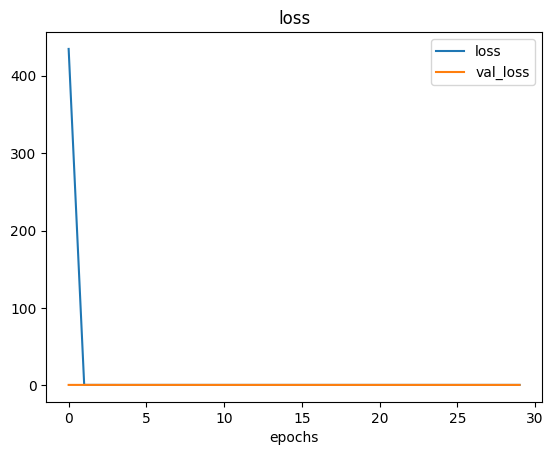

In [71]:
# 損失を可視化
results[['loss', 'val_loss']].plot(title='loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

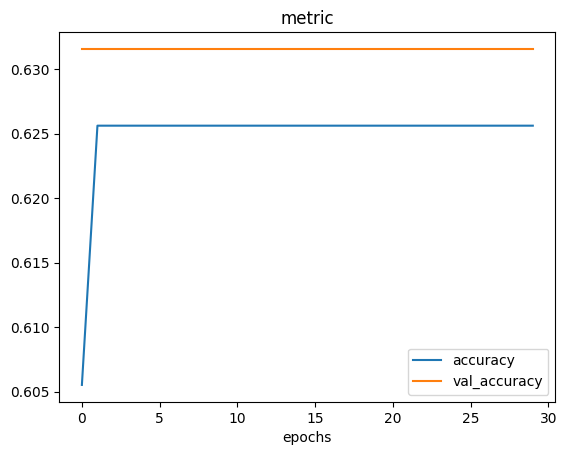

In [72]:
# 正解率を可視化
results[['accuracy', 'val_accuracy']].plot(title='metric')
plt.xlabel('epochs')

損失・正解率ともに横ばいとなっているため、うまく学習が進んでいない事が確認できます。  

### 精度向上のための工夫

学習は正常に行うことができるようになりましたが、ここからが予測精度向上のための試行錯誤の段階になります。  

1 つの予測精度を向上させる方法として、バッチノーマリゼーション (BatchNormalization) が挙げられます。  

バッチノーマリゼーションでは、ミニバッチごとに平均 $\bar x$ と 標準偏差 $\sigma$ を求め、
$$
\begin{align}
x_s &= \frac{x-\bar x}{\sigma} \\\\
\hat x &= \alpha x_s + \beta
\end{align}
$$

のように $\hat x$ へと各変数ごとに変換を行います。ここで、$\alpha$ と $\beta$ はパラメータであり、単純な正規化のように平均 0、標準偏差 1 とするのではなく、平均 $\beta$、標準偏差 $\alpha$ となるように変換を行います。必ずしも平均 0、標準偏差 1 が良いとは限らないためです。  

実装としては、各バッチ毎に平均と標準偏差を定めて標準化を行うといった非常に簡単な手法なのですが、こちらを層に加えることで各変数感のスケールによる差を吸収できます。  

それでは、バッチノーマリゼーションをモデルに追加しましょう。`layers` モジュール内の `BatchNormalization()` クラスを使用します。

In [73]:
#  シードの固定
reset_seed(0)

# モデルのインスタンス化
model = models.Sequential()

# モデルの構築
model.add(layers.BatchNormalization(input_shape=(n_input,))) # バッチノーマリゼーションの層を追加
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(n_output, activation='softmax'))

# モデルのコンパイル
model.compile(optimizer='SGD',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# モデルの学習
history = model.fit(x_train, t_train,
          batch_size=10,
          epochs=30,
          validation_data=(x_test, t_test))

Epoch 1/30
 1/40 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.8000 - loss: 0.4325

/home/kinoko1943/development/github/TKAdvanced/.venv/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8618 - loss: 0.3960 - val_accuracy: 0.3684 - val_loss: 2.2049
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9194 - loss: 0.2862 - val_accuracy: 0.3918 - val_loss: 1.2964
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9245 - loss: 0.2444 - val_accuracy: 0.5673 - val_loss: 0.7483
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9242 - loss: 0.2226 - val_accuracy: 0.7836 - val_loss: 0.4439
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9242 - loss: 0.2096 - val_accuracy: 0.8830 - val_loss: 0.2978
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9251 - loss: 0.2012 - val_accuracy: 0.9298 - val_loss: 0.2274
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9224 - loss: 0.1952 - val_accuracy: 0.9474 - val_loss: 0.1922
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9224 - loss: 0.1904 - val_accuracy: 0.9474 - val_loss: 0.1723
Epo

先程と同様に学習結果をプロットし、確認しましょう。

Text(0.5, 0, 'epochs')

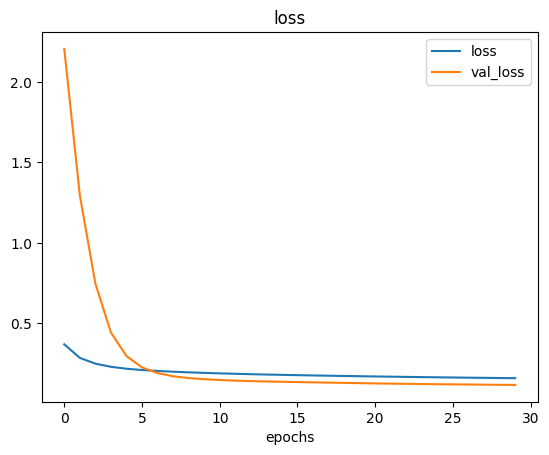

In [150]:
# 学習結果を取得
results = pd.DataFrame(history.history)
# 損失を可視化
results[['loss', 'val_loss']].plot(title='loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

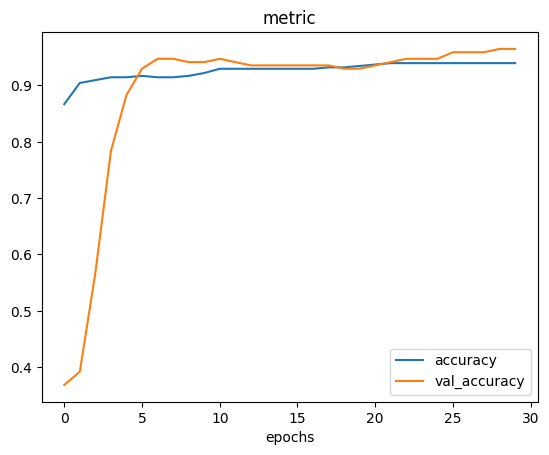

In [75]:
# 正解率を可視化
results[['accuracy', 'val_accuracy']].plot(title='metric')
plt.xlabel('epochs')

飛躍的に正解率が向上しました。正解率の値が良くなっていれば成功です。  

このようにディープラーニングでは、BatchNormalization を含めた細かな精度向上のポイントがあるため、今後も調べながら進めていきましょう。TensorFlow では、多くの機能がすでに実装されているため、上記のコードのように少し付け加えるだけでその効果を検証できるため、非常に便利です。

## 学習済みモデルの保存と推論

学習済みモデルは変数 `model` に格納されています。この学習済みモデルのファイルの書き出し、書き出したモデルを読み込み推論する方法を確認します。  

モデルの保存には `save()` メソッドを使用します。引数に出力先のファイルパスを指定します。  
（Colab 上で保存する場合、下記のようにファイルパスを `/content` から始める必要があります。）  

In [83]:
# モデルの保存
filepath = './content/saved_model.keras'
model.save(filepath)

保存されているファイルを確認しましょう。

In [84]:
!ls ./content/

saved_model.h5	saved_model.keras  saved_model2.keras


### 学習済みモデルをロード

学習済みモデルは `keras.models.load_model(filepath)` を用いて再インスタンス化できます。  
モデルがすでに一度コンパイルされている場合、`load_model` は、学習時の設定を利用して、コンパイルを行います。

In [89]:
from tensorflow.keras.models import Model

# モデルの読み込み
loaded_model = load_model(filepath)

### 予測値の計算

本来であれば学習を終えたモデルは新しく取得したデータに対して推論しますが、今回は試しに学習で使用したデータセットの最初のサンプルに対する予測値を計算してみましょう。

In [104]:
x_new = np.array(x_train[0], dtype=np.float32)
x_new.shape

(10,)

分類のモデルでクラスを推論する場合は `predict()` メソッドを使用します。推論結果はそれぞれのクラスに対する確率になります。推論結果がどちらのクラスなのか確認する際には `argmax()` メソッドを使用します。（値の大きいものを取得することができるメソッドになります。）  

In [105]:
# 予測値の計算
loaded_model.predict(x_new)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(10,), dtype=float32). Expected shape (None, 10), but input has incompatible shape (10,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(10,), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

推論で使用する際には、`(バッチサイズ, 入力変数の数)` という形式となっていないとエラーが起きます。今回であれば、`(1, 10)` が望ましいデータの形と言えます。

In [106]:
x_new = x_new[tf.newaxis]
x_new.shape

(1, 10)

In [107]:
# 確率の計算
y_proba = loaded_model.predict(x_new)
y_proba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[0.94943947, 0.04385144, 0.00670914]], dtype=float32)

In [108]:
# 予測値の計算
y_pred = y_proba.argmax(axis=-1)
y_pred[0]

np.int64(0)

正常に予測できている事が確認できました。  
最後に対応する目標値を確認し、推論結果が正解しているか確認します。

In [109]:
# 目標値の確認
t_train[0]

np.int64(0)

予測値と目標値が一致しており、うまく推論できている事が確認できました。  

## 練習問題 本章のまとめ

本章で学んだ内容を復習しましょう。下記の内容を次のセルに記述し、実行結果を確認してください。（必要に応じてセルの追加を行ってください。）

こちらの[ワインの等級に関するデータセット](https://drive.google.com/file/d/1InIHnFv9N-GoKt2cgAnGD1DqX2TUyrnn/view?usp=sharing)を使用して、ワインの等級の分類を行うニューラルネットワークの構築を行って下さい。テスト用データセットに対し、80% の正解率を目指しましょう。    
実装の手順は下記を参照して下さい。  

- データセットのアップロード
- データセットの準備
  - 入力変数と目的変数の切り分け
  - TensorFlow で計算できるデータの形式に変換
  - 学習用データセットとテスト用データセットの切り分け
- モデルの定義
- 目的関数・最適化手法の選択
- モデルの学習
- 予測精度の評価
- ハイパーパラメータの調整
- 学習済みモデルの保存と推論

*補足*  
- 目的変数は `Class` 列になります。入力変数にはその他の列を全て使用して下さい。  
- データセットの切り分けはテスト用データセットが全体の 30% となるように行って下さい。  
- ハイパーパラメータの調整では、層・ノードの数や活性化関数、バッチノーマリゼーションなど学んだ知識を生かして、試行錯誤を行って下さい。



#### データセットの準備

In [123]:
# データセットのアップロード
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [124]:
df = pd.read_csv('wine_class.csv')
df.head(3)

,Class,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,1,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,1,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185


In [125]:
# 入力変数と目的変数の切り分け
x = df.drop(['Class'], axis=1).values
t = df['Class'].values

In [131]:
# それぞれの形、データ型の確認
print(x.shape, t.shape)
print(x.dtype, t.dtype)

(178, 10) (178,)
float64 int64


In [132]:
# 目標値の最小値が 0 であることを確認
np.unique(t)

array([1, 2, 3])

今回は目標値が 1 から始まっているため、0 から始まるように処理を加えます。

In [133]:
# -1 し、0 からラベルが始まるように変更
t = t - 1
np.unique(t)

array([0, 1, 2])

**学習用データセットとテスト用データセットの切り分け**

In [134]:
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

In [135]:
x_train.shape, x_test.shape

((124, 10), (54, 10))

#### モデルの定義

In [137]:
import os, random

def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
# 入力・出力層のノードの数を定義
n_input, n_output = len(x_train[0]), len(np.unique(t_train))
n_input, n_output

(10, 3)

使用するデータセットの入力変数同士のスケールが異なるため、バッチノーマリゼーション層を組み込み、ミニバッチごとのスケールを統一します。

In [145]:
# シードの固定
reset_seed(1002)

# モデルのインスタンス化
model = models.Sequential()


# モデルの構築
model.addshape=((n_input,)) # バッチノーマリゼーションの層を追加
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(n_output, activation='softmax'))

#### モデルの可視化

In [146]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 目的関数・最適化手法の選択

In [147]:
# モデルのコンパイル
model.compile(optimizer='sgd',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

#### モデルの学習

In [149]:
# モデルの学習
history = model.fit(x_train, t_train,
          batch_size=10,
          epochs=30,
          validation_data=(x_test, t_test),
          )

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5257 - loss: 0.9708 - val_accuracy: 0.5741 - val_loss: 1.7339
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5757 - loss: 0.8960 - val_accuracy: 0.5370 - val_loss: 1.2832
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5998 - loss: 0.8327 - val_accuracy: 0.4815 - val_loss: 1.1369
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6413 - loss: 0.7796 - val_accuracy: 0.4630 - val_loss: 1.0557
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7055 - loss: 0.7342 - val_accuracy: 0.4630 - val_loss: 0.9950
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7330 - loss: 0.6940 - val_accuracy: 0.4815 - val_loss: 0.9360
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8059 - loss: 0.6578 - val_accuracy: 0.5185 - val_loss: 0.8754
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8143 - loss: 0.6252 - val_accuracy: 0.5741 - val_loss:

#### 予測精度の評価

In [151]:
# 学習結果を取得
results = pd.DataFrame(history.history)

Text(0.5, 0, 'epochs')

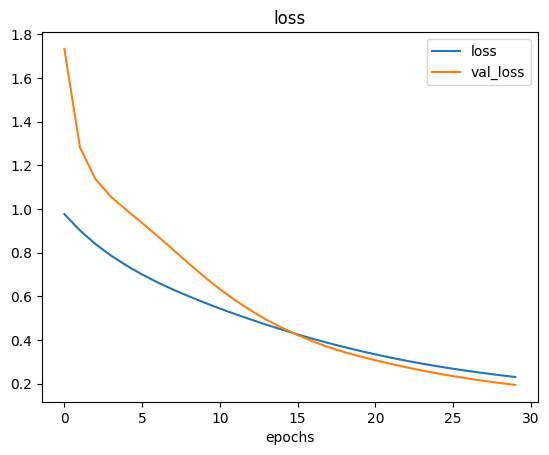

In [152]:
# 損失を可視化
results[['loss', 'val_loss']].plot(title='loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

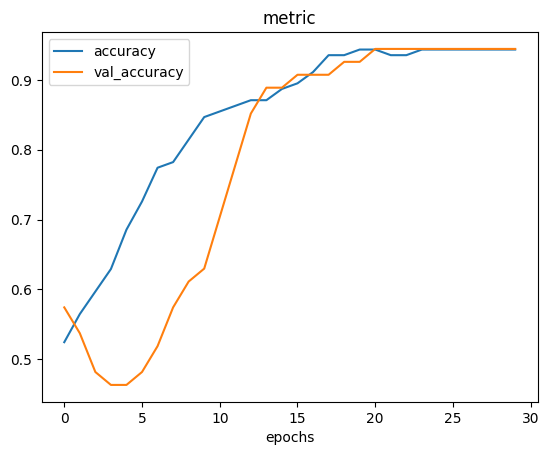

In [154]:
# 正解率を可視化
results[['accuracy', 'val_accuracy']].plot(title='metric')
plt.xlabel('epochs')

テスト用データセットに対する正解率が約 98% となっており、高い予測精度が確認できました。


#### 学習済みモデルの保存と推論

ファイルを `saved_model2` とし、学習済みモデルの保存を行います。

In [155]:
# 学習済みモデルの保存
model.save('./content/saved_model2.keras')

---
© 株式会社キカガク及び国立大学法人 豊橋技術科学大学